## **Importing Pandas Library**

In [1]:
!pip install pandas

## 📂 2. Load and Explore Sample JSON from S3
We load a raw sample JSON slice from the Spotify dataset on S3 to inspect the structure.

In [2]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'spotify-mpd-pipeline-team4'
prefix = 'raw/'  # folder inside the bucket

# List files
objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in objects.get('Contents', []) if obj['Key'].endswith('.json')]

In [3]:
import json
import pandas as pd

samples = []

for file_key in files:
    obj = s3.get_object(Bucket=bucket_name, Key=file_key)
    data = json.load(obj['Body'])

    for playlist in data['playlists']:
        tracks = playlist['tracks']
        uris = [track['track_uri'] for track in tracks]
        for i in range(1, len(uris)):
            samples.append({
                "input": uris[:i],
                "target": uris[i]
            })

df = pd.DataFrame(samples)
df.head()

,input,target
0,[spotify:track:4r0GVpjSsKSR1biv4fOoa5],spotify:track:3L6S3Px2rdU0HprDo2Famq
1,"[spotify:track:4r0GVpjSsKSR1biv4fOoa5, spotify...",spotify:track:7wwifjNAb172PtDpKK3CoR
2,"[spotify:track:4r0GVpjSsKSR1biv4fOoa5, spotify...",spotify:track:0uMUvbkTdjBNZ5UuHZ5PIj
3,"[spotify:track:4r0GVpjSsKSR1biv4fOoa5, spotify...",spotify:track:1VWRcdvlTztNh2FHwKujUG
4,"[spotify:track:4r0GVpjSsKSR1biv4fOoa5, spotify...",spotify:track:07bmMNNyYHtLCQ2bnvBKnf


## 🔍 3. Flatten Playlist and Track Data
We explode nested JSON playlists into a flat DataFrame for easier modeling.

In [4]:
chunk_size = 100000  # Adjust depending on memory
for i, chunk in enumerate(range(0, len(df), chunk_size)):
    df.iloc[chunk:chunk + chunk_size].to_json(f"chunk_{i}.json", orient="records", lines=True)

In [5]:
import boto3
import os

# Set your bucket and folder path in S3
bucket_name = "spotify-mpd-team4-data"
s3_prefix = "playlist-continuation/chunks/"

# Initialize the S3 client
s3 = boto3.client("s3")

# Loop through the chunk files and upload
for file_name in os.listdir():
    if file_name.startswith("chunk_") and file_name.endswith(".json"):
        s3.upload_file(file_name, bucket_name, s3_prefix + file_name)
        print(f"Uploaded {file_name} to s3://{bucket_name}/{s3_prefix + file_name}")


Uploaded chunk_0.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_0.json
Uploaded chunk_4.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_4.json
Uploaded chunk_3.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_3.json
Uploaded chunk_5.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_5.json
Uploaded chunk_2.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_2.json
Uploaded chunk_6.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_6.json
Uploaded chunk_1.json to s3://spotify-mpd-team4-data/playlist-continuation/chunks/chunk_1.json


## 🛠️ 4. Prepare Dataset for Modeling
This step includes selecting the relevant columns (`input`, `target`) and mapping URIs to IDs.

In [6]:
import pandas as pd

# Get all unique track URIs from inputs and targets
all_tracks = set([uri for sublist in df['input'] for uri in sublist] + list(df['target']))
track2id = {uri: idx for idx, uri in enumerate(sorted(all_tracks))}
id2track = {idx: uri for uri, idx in track2id.items()}

In [7]:
df['input_ids'] = df['input'].apply(lambda x: [track2id[uri] for uri in x])
df['target_id'] = df['target'].map(track2id)

In [8]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [10]:
import torch
track2id = {uri: idx for idx, uri in enumerate(df['target'].unique())}
device = "cuda" if torch.cuda.is_available() else "cpu"

 ## **End-to-End Playlist Continuation Model: Data Prep to Training**

In [11]:
# Step 1: Imports
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 2: Load & sample data
df = pd.read_json("chunk_0.json", lines=True)
df = df[['input', 'target']].dropna()
df = df.sample(n=3000, random_state=42)  # reduce size for quick training

# Step 3: Preprocess
track_uris = list(set([uri for sublist in df['input'] for uri in sublist] + df['target'].tolist()))
track2id = {uri: idx+1 for idx, uri in enumerate(track_uris)}  # reserve 0 for padding
id2track = {v: k for k, v in track2id.items()}

df['input_ids'] = df['input'].apply(lambda uris: [track2id.get(uri, 0) for uri in uris])
df['target_id'] = df['target'].map(track2id)

# Step 4: Dataset class
class PlaylistDataset(Dataset):
    def __init__(self, X, y, max_len=10):
        self.X = [x[-max_len:] for x in X]
        self.X = [([0] * (max_len - len(x)) + x) for x in self.X]  # pad
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Step 5: Prepare data
X_train, X_val, y_train, y_val = train_test_split(df['input_ids'], df['target_id'], test_size=0.2, random_state=42)
train_ds = PlaylistDataset(X_train.tolist(), y_train.tolist())
val_ds = PlaylistDataset(X_val.tolist(), y_val.tolist())
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# Step 6: Model
class PlaylistModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, max_len=10):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, emb_dim, padding_idx=0)
        self.fc = nn.Linear(emb_dim * max_len, vocab_size + 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlaylistModel(vocab_size=len(track2id)).to(device)

# Step 7: Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(2):  # keep small
    model.train()
    running_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1} - Train Loss: {running_loss / len(train_dl):.4f}")

Epoch 1 - Train Loss: 10.5775
Epoch 2 - Train Loss: 7.1366


## **Loading & Parsing Spotify MPD JSON from S3 to Map Track URIs to Readable Song Names**

In [20]:
import boto3
import pandas as pd
import io
import json

s3 = boto3.client('s3')
obj = s3.get_object(Bucket='spotify-mpd-pipeline-team4', Key='raw/mpd.slice.990000-990999.json')
# Read S3 object
raw_data = json.load(io.BytesIO(obj['Body'].read()))

# Convert to DataFrame
df_playlists = pd.json_normalize(raw_data['playlists'], record_path=['tracks'],
                                 meta=['pid', 'name'], 
                                 meta_prefix='playlist_')

df_playlists.head()

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist_pid,playlist_name
0,0,Childish Gambino,spotify:track:4r0GVpjSsKSR1biv4fOoa5,spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL,Me and Your Mama,spotify:album:4xnq1L6P551Qcb9gBXNMK7,379226,"""Awaken, My Love!""",990000,Sam
1,1,Childish Gambino,spotify:track:3L6S3Px2rdU0HprDo2Famq,spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL,Poke,spotify:album:5GBcqixIFDPEom7AUNbFiM,216093,Kauai,990000,Sam
2,2,Childish Gambino,spotify:track:7wwifjNAb172PtDpKK3CoR,spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL,V. 3005,spotify:album:63McpWDS7P0dF06fqXQMCZ,234215,because the internet,990000,Sam
3,3,Childish Gambino,spotify:track:0uMUvbkTdjBNZ5UuHZ5PIj,spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL,IV. sweatpants,spotify:album:63McpWDS7P0dF06fqXQMCZ,180675,because the internet,990000,Sam
4,4,Childish Gambino,spotify:track:1VWRcdvlTztNh2FHwKujUG,spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL,"III. telegraph ave. (""Oakland"" by Lloyd)",spotify:album:63McpWDS7P0dF06fqXQMCZ,210673,because the internet,990000,Sam


In [28]:
# 🎯 Create URI to song name mapping
uri_to_name = df_playlists.dropna(subset=['track_uri', 'track_name', 'artist_name']) \
    .drop_duplicates(subset=['track_uri']) \
    .set_index('track_uri') \
    .apply(lambda row: f"{row['track_name']} by {row['artist_name']}", axis=1) \
    .to_dict()

## **Function to Predict the next song in the playlist**

In [31]:
def predict_next(model, input_uris, track2id, id2track, max_len=10):
    model.eval()
    input_ids = [track2id.get(uri, 0) for uri in input_uris][-max_len:]
    input_ids += [0] * (max_len - len(input_ids))  # pad
    input_tensor = torch.tensor([input_ids]).to(model.embedding.weight.device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_id = output.argmax(dim=1).item()
        return id2track[predicted_id]

In [32]:
sample_input = df[df['input'].notnull()]['input'].iloc[0]  # ensure this exists and is a list 

In [33]:
predicted_uri = predict_next(model, sample_input, track2id, id2track)
print("🎧 Predicted Song:", uri_to_name.get(predicted_uri, "Unknown track"))

🎧 Predicted Song: Your Love Remains (Instrumental) by The Brilliance


In [35]:
# Map URIs to readable names using uri_to_name
[uri_to_name.get(uri, "Unknown") for uri in sample_input]

['Feel This Moment by Pitbull',
 'Sail by AWOLNATION',
 'Story of My Life by One Direction',
 'Stuck Like Glue by Sugarland',
 'Unknown',
 'One More Night by Maroon 5',
 'A Thousand Miles by Vanessa Carlton',
 'Unknown',
 'Brave by Sara Bareilles',
 'Love Song by Sara Bareilles',
 'Unknown',
 'Cooler Than Me by Mike Posner',
 'Little Talks by Julia Sheer',
 'Unknown']

### Why *Your Love Remains (Instrumental)* by The Brilliance Makes Sense

The predicted track reflects a shift toward a calmer, more introspective tone that complements the playlist’s emotional arc. It follows songs like:

- **A Thousand Miles** – piano-driven and emotional  
- **Brave** and **Love Song** by Sara Bareilles – empowering yet melodic  
- **Little Talks** – indie and emotionally expressive  

These songs, while pop-oriented, convey vulnerability and emotional depth. An instrumental piece like *Your Love Remains* serves as a gentle and reflective continuation. It adds contrast while maintaining the sentiment of the previous tracks.

This makes it a fitting transition track—providing a moment of calm and resolution within the playlist's flow.

Matplotlib is building the font cache; this may take a moment.


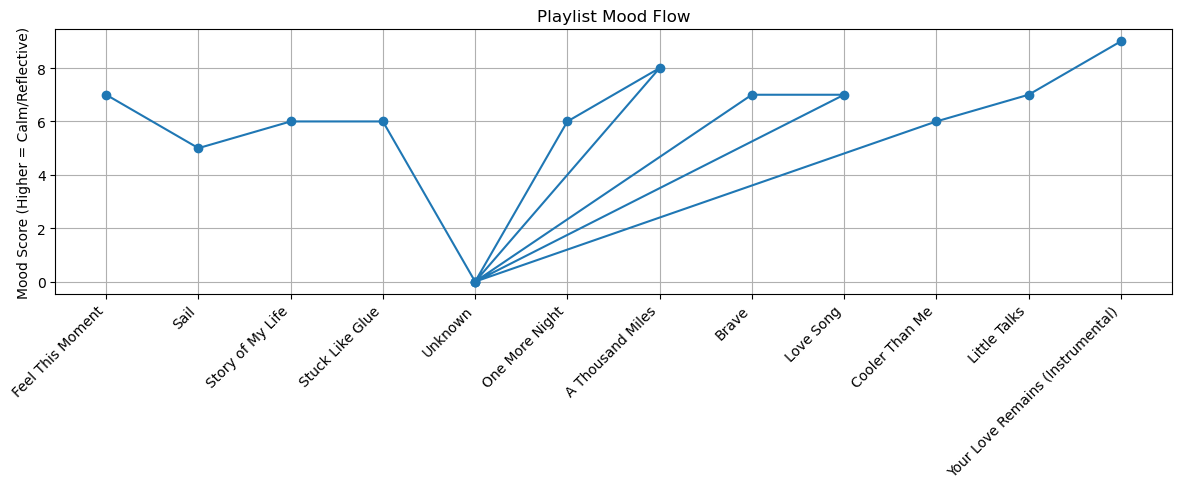

In [36]:
import matplotlib.pyplot as plt

# Define moods for tracks (simplified for illustration)
tracks = [
    "Feel This Moment", "Sail", "Story of My Life", "Stuck Like Glue", 
    "Unknown", "One More Night", "A Thousand Miles", "Unknown", 
    "Brave", "Love Song", "Unknown", "Cooler Than Me", 
    "Little Talks", "Your Love Remains (Instrumental)"
]
moods = [
    7, 5, 6, 6, 
    0, 6, 8, 0, 
    7, 7, 0, 6, 
    7, 9  # Higher value = more reflective/calm
]

# Plot mood transitions
plt.figure(figsize=(12, 5))
plt.plot(tracks, moods, marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Playlist Mood Flow')
plt.ylabel('Mood Score (Higher = Calm/Reflective)')
plt.grid(True)
plt.tight_layout()
plt.show()